In [1]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pint
from pint import UnitRegistry

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [4]:
def to_CI(df):
    def celc(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degC)
        return home.to('degK')

    def ream(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degR)
        return home.to('degK')
    
    celc_features = ['ZT1AB', 'ZTNAC', 'ZTOIL', 'ZT1A', 'GEGTMC', 'ZTNAC_D']
    ream_features = ['ZTAMB']
    
    for cl in celc_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(celc(df[cl].values))
            
    for cl in ream_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(ream(df[cl].values))
    
    return df

def preprocess_file(df, corr_ther, targets):
    def delete_corr(df, ther):
        was_corr = []
        corr = df.corr()
        for row in corr.iterrows():
            for v_ind in range(len(row[1])):
                if row[1][v_ind] > ther and row[1][v_ind] < 1: #ПЕРЕСЧИТАТЬ
                    if (row[0] not in was_corr) and (row[1].index[v_ind] not in was_corr):
                        was_corr.append(row[0])
        return was_corr
    #удалить лишние
    df = df.drop(['flight_datetime', 'engine_id'], axis = 1)
    
    #виды фичей
    to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                         'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                         'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #убрать те у которых больше 2/3 пропущены значения
    for cl in numerical:
        if (cl in df.columns.to_list()) and (len(df[cl]) * 2 / 3 < df[cl].isna().sum()):
            df = df.drop([cl], axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    #заполнить оставшиеся пропуски нулями
    df = df.fillna(0)
    
    #перевести в систему СИ
    df = to_CI(df)

    #убрать скоррелированные фичи
    was_corr = delete_corr(df[numerical], corr_ther)
    df.drop(was_corr, axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #скалировать данные
    numerical_features_df = df[numerical]    
    #исправить типы данных категориальных фичей
    for cl in to_categorical:
        if cl in df.columns.to_list():
            df[cl] = df[cl].astype(str)
            #One Hot Encoding
            one_hot = pd.get_dummies(df[cl],prefix = cl)
            numerical_features_df = pd.concat([numerical_features_df, one_hot], axis=1)
    
    numerical_features_df = pd.concat([numerical_features_df, df[targets]], axis=1)
    return numerical_features_df

In [6]:
df = pd.read_csv("../data/grouped/takeoff_CFM56-7.csv")       
targets = ['DELFN',
 'DELN1',
 'EGTHDM',
 'EGTHDM_D',
 'PCN12',
 'PCN12I',
 'PCN1AR',
 'PCN1BR',
 'PCN1K',
 'SLOATL',
 'SLOATL_D',
 'ZPCN25_D',
 'ZT49_D']

to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                         'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                         'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']

numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))

df = preprocess_file(df, 0.95, targets)
features = list(set(df.columns.to_list()) - set(targets))

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [23]:
targets

['DELFN',
 'DELN1',
 'EGTHDM',
 'EGTHDM_D',
 'PCN12',
 'PCN12I',
 'PCN1AR',
 'PCN1BR',
 'PCN1K',
 'SLOATL',
 'SLOATL_D',
 'ZPCN25_D',
 'ZT49_D']

In [7]:
if 'WBI' in targets:
    targets.remove('WBI')
    
if 'BRAT' in targets:
    targets.remove('BRAT')

In [24]:
X = df[features].values
y = df['SLOATL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from catboost import CatBoostRegressor
import optuna

In [32]:
model = CatBoostRegressor(learning_rate=1,
                          depth=15,
                          n_estimators=30,
                          loss_function='RMSE')

#model = LGBMRegressor()

# Fit model
model.fit(X_train, y_train)
# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))

test_metric_r2_score = r2_score(y_test, y_test_pred)
train_metric_r2_score = r2_score(y_train, y_train_pred)
print('train r2_score', round(train_metric_r2_score, 3))
print('test r2_score', round(train_metric_r2_score, 3))

0:	learn: 3.8719312	total: 413ms	remaining: 12s
1:	learn: 2.9339046	total: 894ms	remaining: 12.5s
2:	learn: 2.4832876	total: 1.36s	remaining: 12.3s
3:	learn: 2.1427722	total: 1.79s	remaining: 11.6s
4:	learn: 1.9005809	total: 2.27s	remaining: 11.3s
5:	learn: 1.7273141	total: 2.75s	remaining: 11s
6:	learn: 1.6168773	total: 3.16s	remaining: 10.4s
7:	learn: 1.5099115	total: 3.57s	remaining: 9.83s
8:	learn: 1.4250011	total: 3.98s	remaining: 9.3s
9:	learn: 1.3415247	total: 4.45s	remaining: 8.9s
10:	learn: 1.2762167	total: 4.93s	remaining: 8.52s
11:	learn: 1.1712637	total: 5.33s	remaining: 7.99s
12:	learn: 1.1024802	total: 5.79s	remaining: 7.57s
13:	learn: 1.0531218	total: 6.26s	remaining: 7.16s
14:	learn: 1.0043667	total: 6.69s	remaining: 6.69s
15:	learn: 0.9187568	total: 7.12s	remaining: 6.23s
16:	learn: 0.8715007	total: 7.58s	remaining: 5.8s
17:	learn: 0.8317811	total: 8.06s	remaining: 5.37s
18:	learn: 0.7806571	total: 8.48s	remaining: 4.91s
19:	learn: 0.7171543	total: 8.94s	remaining: 4.4

In [33]:
def objective(trial):
    param = {}
    param['learning_rate'] = 1
    param['depth'] = trial.suggest_int('depth', 11, 15)
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 30
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['loss_function'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_test.copy(), y_test.copy())],
                  early_stopping_rounds=100)
    loss = sqrt(mean_squared_error(y_test, regressor.predict(X_test.copy())))
    return loss

In [34]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2023-05-16 22:26:53,937] A new study created in memory with name: no-name-79d32f1a-3111-4d32-b32b-132fb17db185
[I 2023-05-16 22:26:59,296] Trial 3 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:01,713] Trial 5 finished with value: 2.38947014753053 and parameters: {'depth': 12}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:04,748] Trial 7 finished with value: 2.516847865504613 and parameters: {'depth': 13}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:04,974] Trial 2 finished with value: 2.516847865504613 and parameters: {'depth': 13}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:06,360] Trial 8 finished with value: 2.38947014753053 and parameters: {'depth': 12}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:08,739] Trial 4 finished with value: 2.7602872043746634 and parameters: {'depth': 14}. Best is tr

[I 2023-05-16 22:27:46,868] Trial 48 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:48,465] Trial 50 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:48,467] Trial 49 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:27:50,214] Trial 51 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:28:03,499] Trial 56 finished with value: 2.7602872043746634 and parameters: {'depth': 14}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:28:05,275] Trial 57 finished with value: 2.7602872043746634 and parameters: {'depth': 14}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:28:07,116] Trial 53 finished with value: 2.7376

[I 2023-05-16 22:28:39,818] Trial 97 finished with value: 2.2380803959165902 and parameters: {'depth': 11}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:28:41,648] Trial 91 finished with value: 2.516847865504613 and parameters: {'depth': 13}. Best is trial 3 with value: 2.2380803959165902.
[I 2023-05-16 22:28:43,662] Trial 99 finished with value: 2.516847865504613 and parameters: {'depth': 13}. Best is trial 3 with value: 2.2380803959165902.


In [35]:
study.best_value

2.2380803959165902

Text(0.5, 1.0, 'Feature Importance')

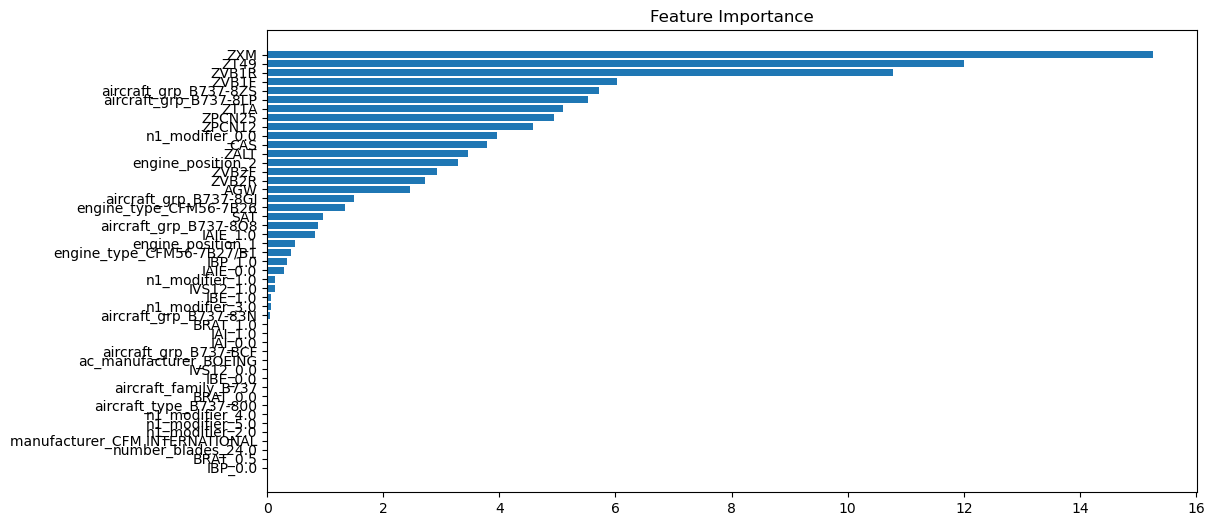

In [36]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')